# Imports

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Lambda,  Multiply, GlobalAveragePooling2D, Dense, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from tensorflow.keras.layers import Add, Conv2D, Input
import tensorflow as tf

In [2]:
def load_images_from_folder(folder, target_size=(128, 128)):
    images = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.tif'):
            img_path = os.path.join(folder, filename)
            img = cv2.imread(img_path)
            img = cv2.resize(img, target_size)
            img = img / 255.0  # Normalize to [0, 1]
            images.append(img)
    return np.array(images)

def load_ground_truth_masks(folder, target_size=(128, 128)):
    masks = []
    for filename in sorted(os.listdir(folder)):
        if filename.endswith('.bmp'):
            mask_path = os.path.join(folder, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load mask as grayscale
            mask = cv2.resize(mask, target_size)
            mask = mask / 255.0  # Normalize to [0, 1]
            masks.append(mask)
    return np.array(masks)

def filter_test_images_with_masks(test_folder):
    test_images_with_masks = []
    for folder_name in os.listdir(test_folder):
        if os.path.isdir(os.path.join(test_folder, folder_name)):
            gt_folder = os.path.join(test_folder, folder_name + '_gt')
            if os.path.exists(gt_folder):
                test_images_with_masks.append(folder_name)
    return test_images_with_masks

## Model Building

In [3]:
from tensorflow.keras.applications import VGG16

# Load the VGG16 model, excluding the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Freeze the layers of VGG16 to keep the pretrained weights
for layer in base_model.layers:
    layer.trainable = False

# Build the autoencoder model using VGG16 as a feature extractor
input_img = Input(shape=(128, 128, 3))

# Feature extraction with VGG16
features = base_model(input_img)

# Flatten the feature map
x = Flatten()(features)
x = Dense(512, activation='relu')(x)

# Reshape and decode
x = Dense(8 * 8 * 512, activation='relu')(x)
x = Reshape((8, 8, 512))(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)

In [4]:
autoencoder = Model(input_img, x)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 512)               4194816   
                                                                 
 dense_1 (Dense)             (None, 32768)             16809984  
                                                                 
 reshape (Reshape)           (None, 8, 8, 512)         0         
                                                                 
 up_sampling2d (UpSampling2  (None, 16, 16, 512)       0     

In [5]:
train_folder = 'C:/Users/ranja/Downloads/UCSD_Anomaly_Dataset/UCSDped1/Train'
test_folder = 'C:/Users/ranja/Downloads/UCSD_Anomaly_Dataset/UCSDped1/Test'

# Load training images
train_images = []
for subfolder in os.listdir(train_folder):
    path = os.path.join(train_folder, subfolder)
    if os.path.isdir(path):  # Check if it is a directory
        train_images.append(load_images_from_folder(path))

train_images = np.concatenate(train_images, axis=0)

# Split data into training and validation sets
X_train, X_val = train_test_split(train_images, test_size=0.2, random_state=42)

# Filter test images with ground truth masks
test_images_with_masks = filter_test_images_with_masks(test_folder)

# Load test images and ground truth masks
test_images, ground_truth_masks = [], []
for subfolder in test_images_with_masks:
    image_path = os.path.join(test_folder, subfolder)
    mask_path = os.path.join(test_folder, subfolder + '_gt')
    
    test_images.append(load_images_from_folder(image_path))
    ground_truth_masks.append(load_ground_truth_masks(mask_path))

# Flatten the lists
test_images = [item for sublist in test_images for item in sublist]
ground_truth_masks = [item for sublist in ground_truth_masks for item in sublist]

## Model Training

In [6]:
# Train the autoencoder
autoencoder.fit(X_train, X_train,
                epochs=30,
                batch_size=32,
                shuffle=True,
                validation_data=(X_val, X_val))

Epoch 1/30
170/170 [==============================] - 1008s 6s/step - loss: 0.0083 - val_loss: 0.0048
Epoch 2/30
170/170 [==============================] - 999s 6s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 3/30
170/170 [==============================] - 1000s 6s/step - loss: 0.0039 - val_loss: 0.0038
Epoch 4/30
170/170 [==============================] - 20261s 120s/step - loss: 0.0036 - val_loss: 0.0036
Epoch 5/30
170/170 [==============================] - 1158s 7s/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/30
170/170 [==============================] - 1125s 7s/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/30
170/170 [==============================] - 1106s 7s/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/30
170/170 [==============================] - 1102s 6s/step - loss: 0.0030 - val_loss: 0.0032
Epoch 9/30
170/170 [==============================] - 1196s 7s/step - loss: 0.0028 - val_loss: 0.0028
Epoch 10/30
170/170 [==============================] - 1091s 6s/step - loss: 0.0

# Model Visualization and Prediction

In [8]:
# mse threshold = 0.029167555302614903 95 percentile run 

In [144]:
threshold = 0.200

In [145]:
# Predict on test images
reconstructed_images = autoencoder.predict(np.array(test_images))

63/63 [==============================] - 94s 1s/step


In [146]:
def generate_anomaly_masks(original, reconstructed, threshold=None):
    # Compute reconstruction error using Mean Squared Error
    error = np.mean(np.square(original - reconstructed), axis=-1)
    
    # Calculate dynamic threshold based on the percentile of errors
    if threshold is None:
        # Flatten the error array and calculate the 95th percentile threshold
        threshold = np.percentile(error.flatten(), 95)
    # print(threshold)
    
    # Generate anomaly masks based on the dynamic threshold
    anomaly_masks = (error > threshold).astype(np.uint8) * 255
    return anomaly_masks

In [147]:
# Generate anomaly masks for test images
anomaly_masks = generate_anomaly_masks(np.array(test_images), reconstructed_images, threshold)

In [148]:
def overlay_masks_on_images(images, masks, alpha=0.5):
    overlaid_images = []
    for img, mask in zip(images, masks):
        # Ensure the image and mask are the same data type
        img = img.astype(np.float32)
        mask_rgb = np.stack([mask] * 3, axis=-1).astype(np.float32)
        
        # Normalize the mask to range [0, 1] if not already
        mask_rgb /= mask_rgb.max()
        
        # Overlay the mask on the image
        overlaid = cv2.addWeighted(img, 1 - alpha, mask_rgb, alpha, 0)
        overlaid_images.append(overlaid)
    return overlaid_images

In [149]:
# Overlay anomaly masks on test images
overlaid_images = overlay_masks_on_images(test_images, anomaly_masks)

In [150]:
def evaluate_masks(predicted_masks, ground_truth_masks, threshold=0.5):
    f1_scores = []
    for predicted, ground_truth in zip(predicted_masks, ground_truth_masks):
        predicted_binary = (predicted > threshold).astype(np.uint8)
        ground_truth_binary = (ground_truth > threshold).astype(np.uint8)
        f1 = f1_score(ground_truth_binary.flatten(), predicted_binary.flatten())
        f1_scores.append(f1)
    return np.mean(f1_scores)

In [151]:
def load_images_and_masks(test_folder):
    test_images_with_masks = []
    ground_truth_masks = []

    for folder_name in sorted(os.listdir(test_folder)):
        image_folder = os.path.join(test_folder, folder_name)
        gt_folder = os.path.join(test_folder, folder_name + '_gt')

        if os.path.isdir(image_folder) and os.path.exists(gt_folder):
            image_files = sorted(os.listdir(image_folder))
            mask_files = sorted(os.listdir(gt_folder))

            for img_file, mask_file in zip(image_files, mask_files):
                if img_file.endswith('.tif') and mask_file.endswith('.bmp'):
                    img_path = os.path.join(image_folder, img_file)
                    mask_path = os.path.join(gt_folder, mask_file)

                    img = cv2.imread(img_path)
                    img = cv2.resize(img, (128, 128))
                    img = img / 255.0  # Normalize image

                    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
                    mask = cv2.resize(mask, (128, 128))
                    mask = mask / 255.0  # Normalize mask

                    test_images_with_masks.append(img)
                    ground_truth_masks.append(mask)

    return np.array(test_images_with_masks), np.array(ground_truth_masks)


In [152]:
# Load the test images and their corresponding ground truth masks
test_images_with_masks, ground_truth_masks = load_images_and_masks(test_folder)

In [153]:
# Generate predictions for images that have ground truth masks
reconstructed_images = autoencoder.predict(test_images_with_masks)

# Generate anomaly masks for these images
anomaly_masks = generate_anomaly_masks(test_images_with_masks, reconstructed_images, threshold)

63/63 [==============================] - 189s 3s/step


In [154]:
# Evaluate the anomaly masks against the ground truth masks
f1_scores = evaluate_masks(anomaly_masks, ground_truth_masks, threshold)
print(f'F1 Score for images with masks: {f1_scores}')

F1 Score for images with masks: 0.058727911747149066


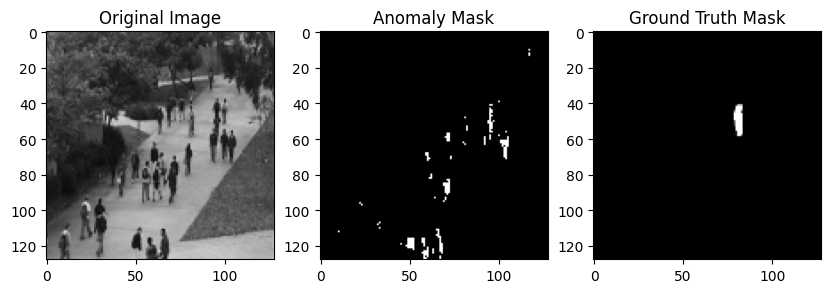

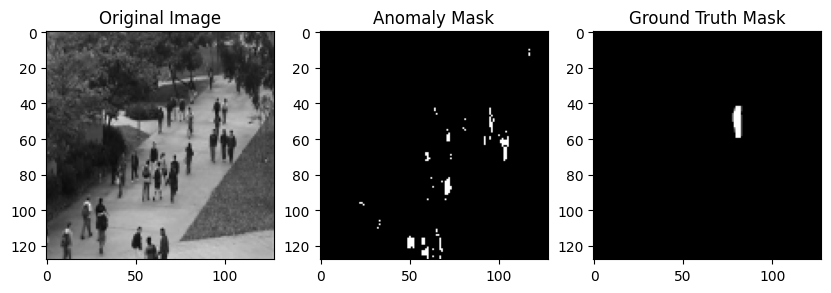

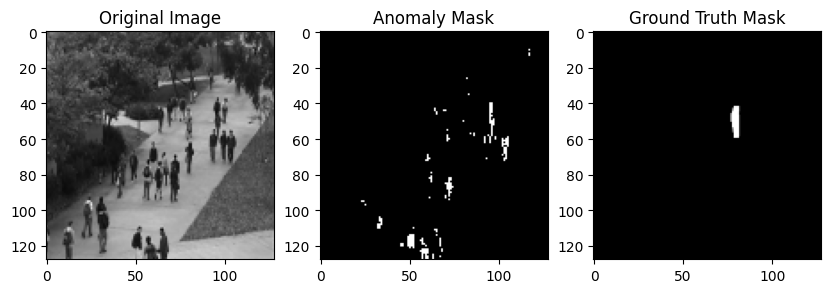

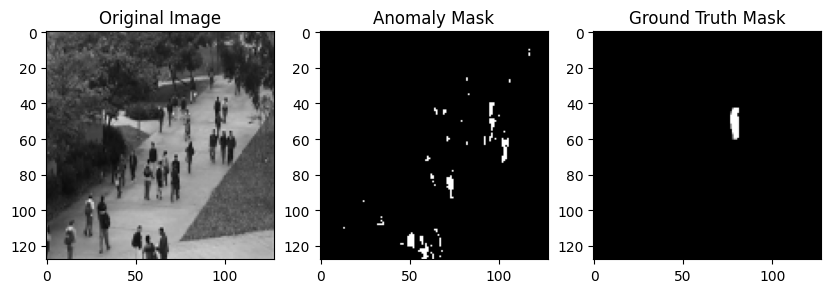

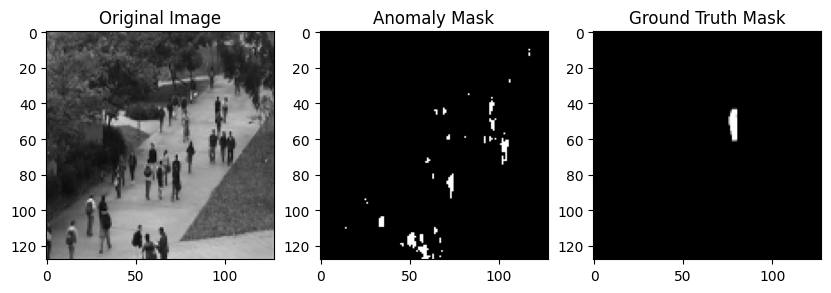

In [155]:
# Visualize 5 results starting from index 20
start_index = 130
num_images_to_display = 5

for i in range(start_index, start_index + num_images_to_display):
    if i >= len(test_images_with_masks):
        break  # Prevents index out of range errors if less than 25 images are available
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images_with_masks[i])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(anomaly_masks[i], cmap='gray')
    plt.title('Anomaly Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_masks[i], cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()

1/1 [==============================] - 0s 411ms/step


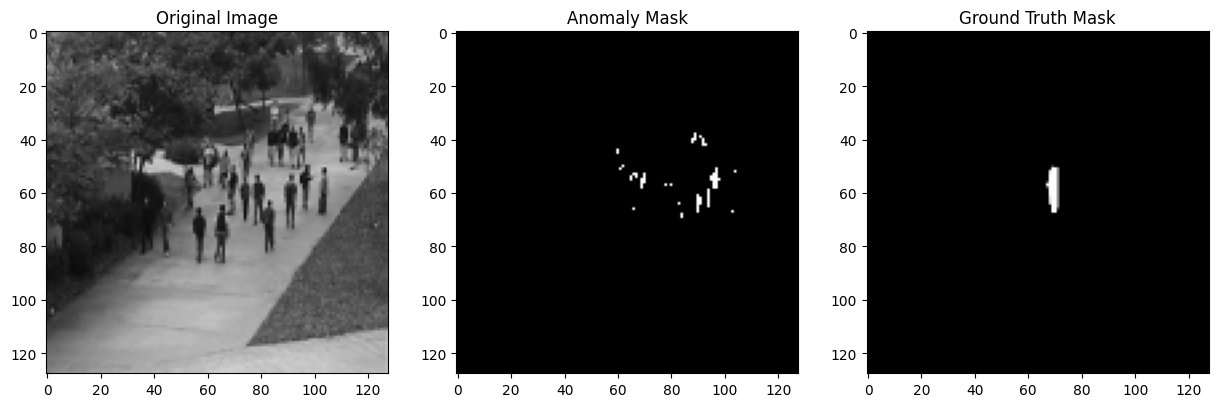

In [156]:
def load_image_and_mask(image_path, mask_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (128, 128))
    img = img / 255.0  # Normalize image

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (128, 128))
    mask = mask / 255.0  # Normalize mask

    return img, mask

def visualize_image_and_masks(folder_name, image_name, test_folder):
    image_path = os.path.join(test_folder, folder_name, image_name)
    mask_path = os.path.join(test_folder, folder_name + '_gt', image_name.replace('.tif', '.bmp'))

    if os.path.exists(image_path) and os.path.exists(mask_path):
        img, ground_truth_mask = load_image_and_mask(image_path, mask_path)

        # Predict the reconstruction and generate the anomaly mask
        reconstructed_image = autoencoder.predict(np.expand_dims(img, axis=0))[0]
        anomaly_mask = generate_anomaly_masks(img, reconstructed_image, threshold = 0.23)

        # Visualize the results
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title('Original Image')

        plt.subplot(1, 3, 2)
        plt.imshow(anomaly_mask, cmap='gray')
        plt.title('Anomaly Mask')

        plt.subplot(1, 3, 3)
        plt.imshow(ground_truth_mask, cmap='gray')
        plt.title('Ground Truth Mask')

        plt.show()
    else:
        print("Image or mask file does not exist.")

# Specify the folder name and image name you want to visualize
folder_name = 'Test018'
image_name = '077.tif'
test_folder = 'C:/Users/ranja/Downloads/UCSD_Anomaly_Dataset/UCSDped1/Test'  # Specify the path to the test folder

# Visualize the specified image and its corresponding masks
visualize_image_and_masks(folder_name, image_name, test_folder)

In [157]:
# Predict on test images with ground truth masks
reconstructed_images = autoencoder.predict(test_images_with_masks)

# Generate anomaly masks
anomaly_masks = generate_anomaly_masks(test_images_with_masks, reconstructed_images, threshold)

63/63 [==============================] - 192s 3s/step


In [158]:
# Evaluate the anomaly masks
f1_scores = evaluate_masks(anomaly_masks, ground_truth_masks, threshold)
print(f'F1 Score for images with masks: {f1_scores}')

F1 Score for images with masks: 0.058727911747149066


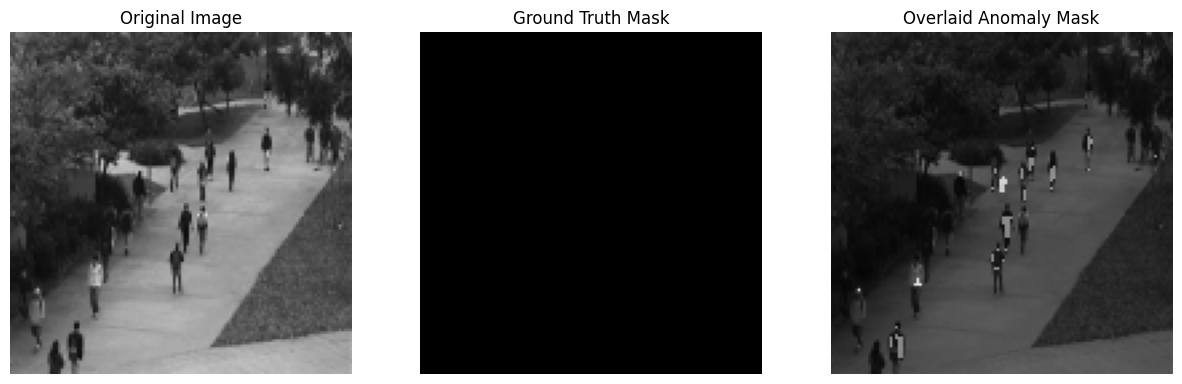

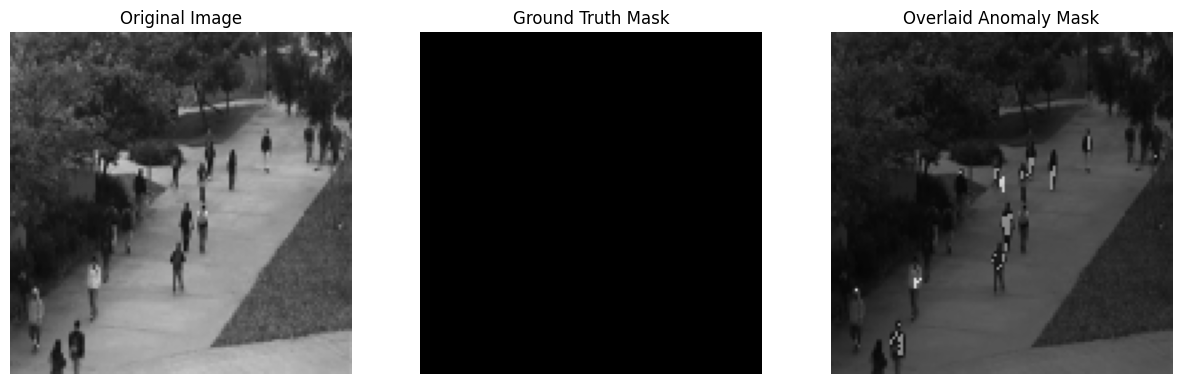

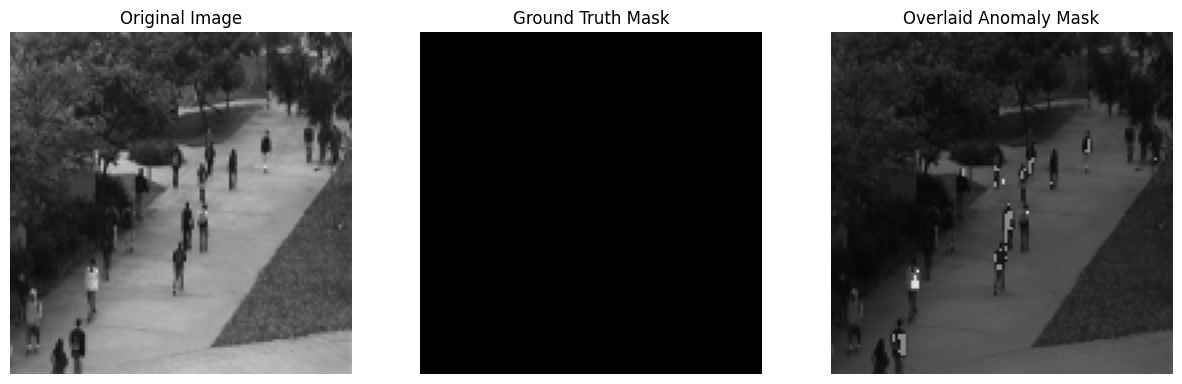

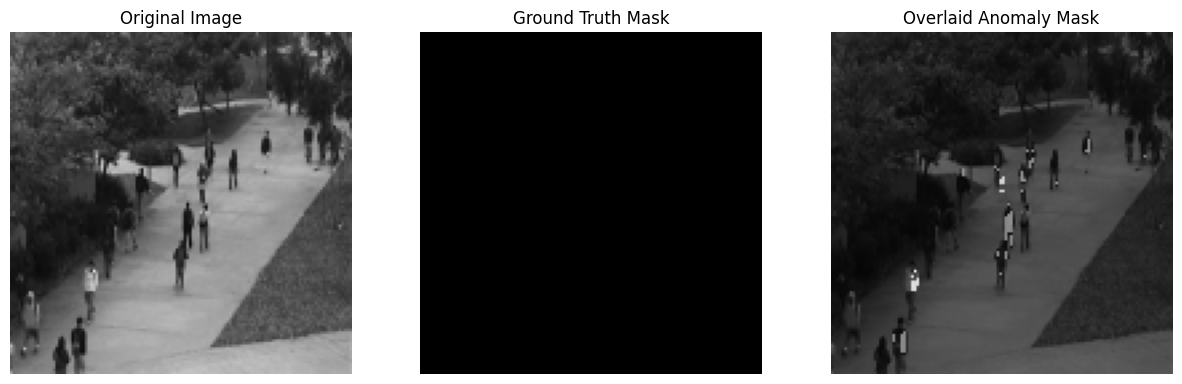

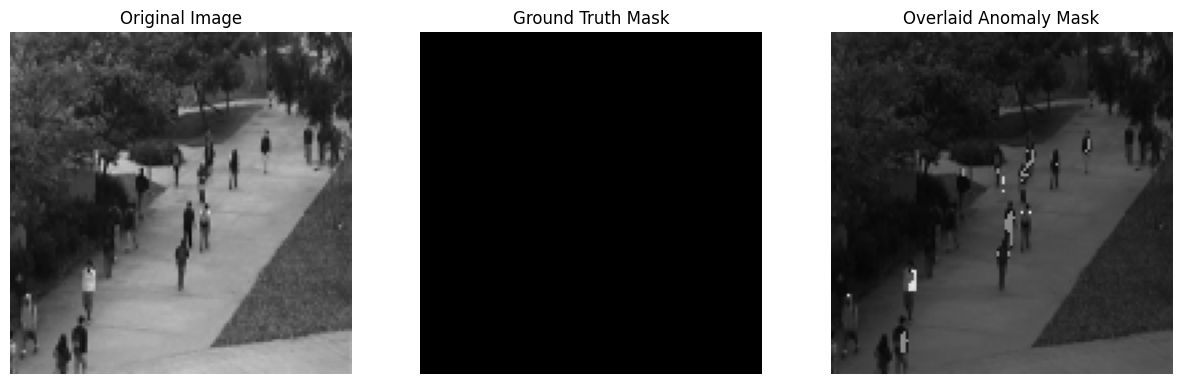

In [159]:
# Visualize some of the results
num_visualizations = 5
overlaid_images = overlay_masks_on_images(test_images_with_masks[:num_visualizations], anomaly_masks[:num_visualizations])

for i in range(num_visualizations):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(test_images_with_masks[i])
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(ground_truth_masks[i], cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Overlaid Anomaly Mask")
    plt.imshow(overlaid_images[i])
    plt.axis('off')

    plt.show()

### For threshold = 0.100

In [160]:
threshold = 0.100
# Predict on test images
reconstructed_images = autoencoder.predict(np.array(test_images))

63/63 [==============================] - 211s 3s/step


In [162]:
# Generate anomaly masks for test images
anomaly_masks = generate_anomaly_masks(np.array(test_images), reconstructed_images, threshold)

In [163]:
# Overlay anomaly masks on test images
overlaid_images = overlay_masks_on_images(test_images, anomaly_masks)
# Load the test images and their corresponding ground truth masks
test_images_with_masks, ground_truth_masks = load_images_and_masks(test_folder)

In [164]:
# Generate predictions for images that have ground truth masks
reconstructed_images = autoencoder.predict(test_images_with_masks)

# Generate anomaly masks for these images
anomaly_masks = generate_anomaly_masks(test_images_with_masks, reconstructed_images, threshold)

63/63 [==============================] - 231s 4s/step


In [165]:
# Evaluate the anomaly masks against the ground truth masks
f1_scores = evaluate_masks(anomaly_masks, ground_truth_masks, threshold)
print(f'F1 Score for images with masks: {f1_scores}')

F1 Score for images with masks: 0.09421859401721783


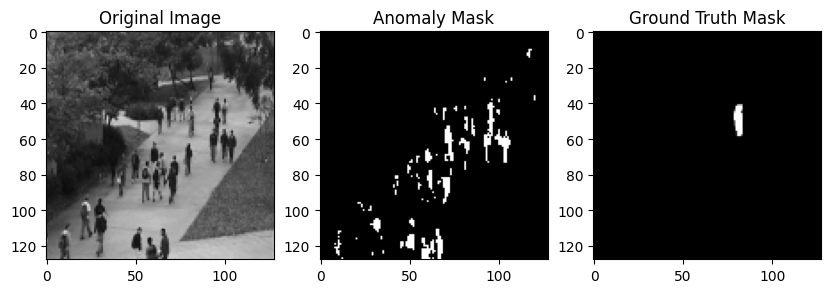

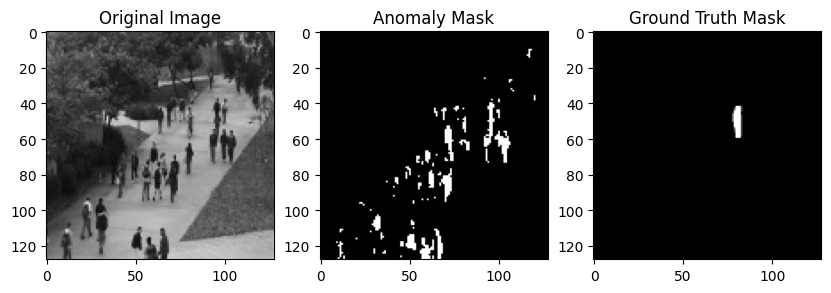

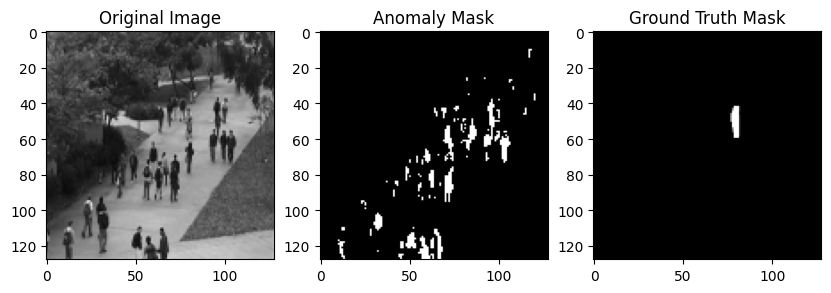

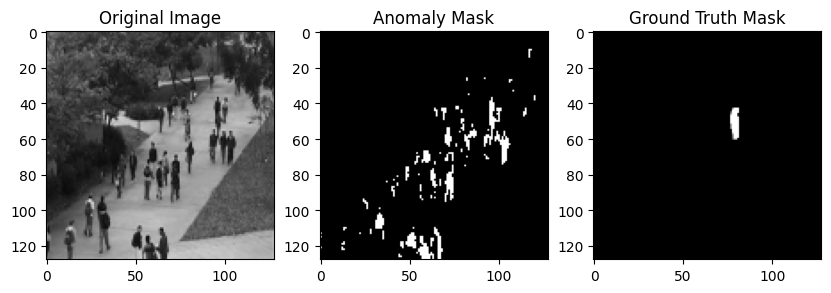

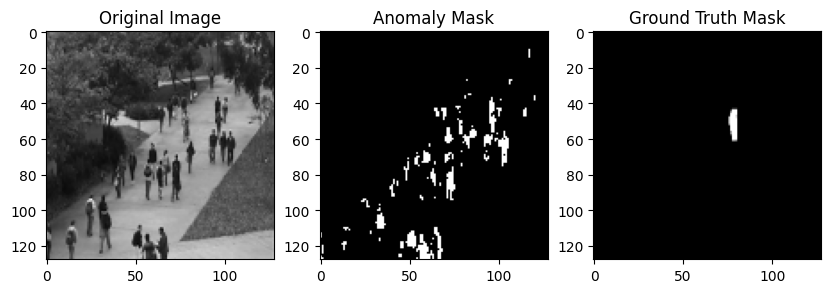

In [166]:
# Visualize 5 results starting from index 20
start_index = 130
num_images_to_display = 5

for i in range(start_index, start_index + num_images_to_display):
    if i >= len(test_images_with_masks):
        break  # Prevents index out of range errors if less than 25 images are available
    
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_images_with_masks[i])
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(anomaly_masks[i], cmap='gray')
    plt.title('Anomaly Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(ground_truth_masks[i], cmap='gray')
    plt.title('Ground Truth Mask')

    plt.show()